In [36]:
from mplsoccer import Pitch, VerticalPitch, Standardizer
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
import matplotlib as mpl
from splink.duckdb.duckdb_linker import DuckDBLinker
from splink.duckdb.duckdb_comparison_library import levenshtein_at_thresholds
%config InlineBackend.figure_format='retina'

In [37]:
WYSCOUT = os.path.join('..', 'data', 'wyscout')
STATSBOMB = os.path.join('..', 'data', 'statsbomb')

Load data

In [38]:
df_wyscout_event = pd.read_parquet(os.path.join(WYSCOUT, 'event_overlap.parquet'))
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_wyscout_match = pd.read_parquet(os.path.join(WYSCOUT, 'match.parquet'))
df_wyscout_match_overlap = pd.read_parquet(os.path.join(WYSCOUT, 'match_overlap.parquet'))
df_wyscout_player = pd.read_parquet(os.path.join(WYSCOUT, 'player.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))
df_statsbomb_tactic = pd.read_parquet(os.path.join(STATSBOMB, 'tactic.parquet'))
df_statsbomb_lineup = pd.read_parquet(os.path.join(STATSBOMB, 'lineup.parquet'))

Number of passes for starting players from StatsBomb data

In [39]:
#df_start = df_statsbomb_event.loc[df_statsbomb_event.type_name=='Starting XI', ['id']]
#df_start = df_start.merge(df_statsbomb_tactic, how='left')
#df_start = df_start[['match_id', 'player_id']]
#df_pass = df_statsbomb_event[df_statsbomb_event.type_name == 'Pass'].copy()
#df_pass_start = df_start.merge(df_pass, on=['match_id', 'player_id'], how='inner')
#df_pass_start.groupby(['match_id','player_id']).type_name.count().mean()
# 42.326760995045206

Games per competition

In [40]:
df_statsbomb_match.competition_name.value_counts()

competition_name
La Liga                    868
Ligue 1                    435
Premier League             418
Serie A                    381
1. Bundesliga              340
FA Women's Super League    326
FIFA World Cup             147
Women's World Cup          116
Indian Super league        115
UEFA Euro                  102
African Cup of Nations      52
NWSL                        36
Copa America                32
UEFA Women's Euro           31
Champions League            18
Major League Soccer          6
Copa del Rey                 3
UEFA Europa League           3
Liga Profesional             2
North American League        1
FIFA U20 World Cup           1
Name: count, dtype: int64

In [41]:
df_statsbomb_match.groupby(['competition_name', 'season_name']).match_id.count()

competition_name        season_name
1. Bundesliga           2015/2016      306
                        2023/2024       34
African Cup of Nations  2023            52
Champions League        1970/1971        1
                        1971/1972        1
                                      ... 
UEFA Euro               2024            51
UEFA Europa League      1988/1989        3
UEFA Women's Euro       2022            31
Women's World Cup       2019            52
                        2023            64
Name: match_id, Length: 74, dtype: int64

% Shots belonging to Barcelona 

In [42]:
num_barca_shots = ((df_statsbomb_event.team_name=='Barcelona') & (df_statsbomb_event.type_name=='Shot')).sum()
num_total_shots = (df_statsbomb_event.type_name=='Shot').sum()
print('Proportion of shots taken by Barcelona in StatsBomb data:', round(num_barca_shots/num_total_shots * 100, 1))

Proportion of shots taken by Barcelona in StatsBomb data: 9.6


Number shots relating to Messi

In [43]:
num_messi_shots = ((df_statsbomb_event.player_name == 'Lionel Andrés Messi Cuccittini') &
                   (df_statsbomb_event.type_name=='Shot')).sum()

In [44]:
print('Number of Messi shots in the StatsBomb dataset', num_messi_shots)
print('Number of total shots in the StatsBomb dataset', num_total_shots)

Number of Messi shots in the StatsBomb dataset 2670
Number of total shots in the StatsBomb dataset 87111


Combine wyscout match

In [45]:
df_wyscout_match = pd.concat([df_wyscout_match, df_wyscout_match_overlap])

Games in the Wyscout data

In [46]:
print(len(df_wyscout_match))

1941


In [47]:
df_wyscout_match.groupby(['season_name', 'competition_name']).season_name.count()

season_name  competition_name
2016         UEFA Euro            51
2017/2018    Bundesliga          306
             La Liga             380
             Ligue 1             380
             Premier League      380
             Serie A             380
2018         FIFA World Cup       64
Name: season_name, dtype: int64

In [48]:
df_statsbomb_shots = df_statsbomb_event[(df_statsbomb_event.type_name=='Shot')&
                                        (df_statsbomb_event.sub_type_name!='Penalty')].dropna(how='all', axis=1).copy()
df_wyscout_shots = df_wyscout_event[((df_wyscout_event.eventName=='Shot')|
                                    (df_wyscout_event.subEventName=='Free kick shot')) &
                                    (df_wyscout_event['matchPeriod']!='P')].copy()

Subset StatsBomb overlap

In [49]:
mask_sb_overlap = ((df_statsbomb_match.competition_name == 'FIFA World Cup')|
                   ((df_statsbomb_match.competition_name == 'La Liga') & (df_statsbomb_match.season_name == '2017/2018')))
overlap_id = df_statsbomb_match.loc[mask_sb_overlap, 'match_id']
df_statsbomb_event = df_statsbomb_event[df_statsbomb_event.match_id.isin(overlap_id)].copy()

Number of non-penalty shots in the Wyscout data

In [50]:
mask_shot_wy = (((df_wyscout_event.eventName=='Shot') | (df_wyscout_event.subEventName=='Free kick shot')) & 
                (df_wyscout_event['matchPeriod']!='P'))
print('Number of non-penalty shots:', mask_shot_wy.sum())

Number of non-penalty shots: 2330


Number of no-penalty shots in the StatsBomb data

In [51]:
mask_shot_sb = (df_statsbomb_event.type_name == 'Shot') & (df_statsbomb_event.sub_type_name!='Penalty')
print('Number of non-penalty shots - StatsBomb:', mask_shot_sb.sum())

Number of non-penalty shots - StatsBomb: 4735


Add match_id from other dataset

In [52]:
df_id1 = df_wyscout_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']].copy()
df_id2 = df_statsbomb_match[['match_id', 'home_team_name', 'away_team_name', 'home_score', 'away_score', 'kick_off']].copy()
df_id1['kick_off'] = pd.to_datetime(df_id1.kick_off.dt.date)
df_id2['kick_off'] = pd.to_datetime(df_id2.kick_off.dt.date)
df_overlap = df_id1.merge(df_id2, on=['home_team_name', 'away_team_name', 'home_score', 'kick_off'], how='inner', 
                          suffixes=['_wyscout', '_statsbomb'])
df_overlap = df_overlap[['match_id_wyscout', 'match_id_statsbomb']]
df_statsbomb_event = df_statsbomb_event.merge(df_overlap, left_on='match_id', right_on='match_id_statsbomb', how='left')
df_wyscout_event = df_wyscout_event.merge(df_overlap, left_on='match_id', right_on='match_id_wyscout', how='left')

Add team name to Wyscout

In [53]:
df_team1 = df_wyscout_match[['home_team_id', 'home_team_name']].copy()
df_team1.rename({'home_team_id': 'team_id','home_team_name': 'team_name'}, axis=1, inplace=True)
df_team2 = df_wyscout_match[['away_team_id', 'away_team_name']].copy()
df_team2.rename({'away_team_id': 'team_id','away_team_name': 'team_name'}, axis=1, inplace=True)
df_teams = pd.concat([df_team1, df_team2]).drop_duplicates()
df_wyscout_event = df_wyscout_event.merge(df_teams, on='team_id', how='left')

Add player name to Wyscout. I am going to seperate out the last part of the name, the first part of the name and anything inbetween. This may not be technically accurate, but it's easier to join

In [54]:
df_wyscout_player['fullName'] = (df_wyscout_player.firstName + ' ' + df_wyscout_player.lastName).str.strip()
player_name_series = df_wyscout_player.fullName.str.split(' ')
df_wyscout_player['firstName'] = player_name_series.apply(lambda x: x[0] if isinstance(x, list) else None)
df_wyscout_player['middleName'] = player_name_series.apply(lambda x: ' '.join(x[1:-1]) if isinstance(x, list) else None)
df_wyscout_player['lastName'] = player_name_series.apply(lambda x: x[-1] if isinstance(x, list) else None)
df_wyscout_player['middleName'] = df_wyscout_player['middleName'].str.strip()
df_wyscout_player['Name'] = ((df_wyscout_player['firstName'] + ' ' + df_wyscout_player['middleName']).str.strip()
                             + ' ' + df_wyscout_player['lastName'])
df_wyscout_event = df_wyscout_event.merge(df_wyscout_player, how='left')

Add player name to StatsBomb

In [55]:
player_name_series = df_statsbomb_event.player_name.str.strip().str.replace(pat='"', repl="'").str.split(' ')
df_statsbomb_event['firstName'] = player_name_series.apply(lambda x: x[0] if isinstance(x, list) else None)
df_statsbomb_event['middleName'] = player_name_series.apply(lambda x: ' '.join(x[1:-1]) if isinstance(x, list) else None)
df_statsbomb_event['middleName'] = df_statsbomb_event['middleName'].str.strip()
df_statsbomb_event['lastName'] = player_name_series.apply(lambda x: x[-1] if isinstance(x, list) else None)
df_statsbomb_event['Name'] = ((df_statsbomb_event['firstName'] + ' ' + df_statsbomb_event['middleName']).str.strip()
                              + ' ' + df_statsbomb_event['lastName'])

Subset non-penalty shots

In [56]:
df_statsbomb_shots = df_statsbomb_event[(df_statsbomb_event.type_name=='Shot')&
                                        (df_statsbomb_event.sub_type_name!='Penalty')].dropna(how='all', axis=1).copy()
df_wyscout_shots = df_wyscout_event[((df_wyscout_event.eventName=='Shot')|
                                    (df_wyscout_event.subEventName=='Free kick shot')) &
                                    (df_wyscout_event['matchPeriod']!='P')].copy()

In [57]:
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 4735
Number of Wyscout shots: 2330


Add consistent seconds (eventSec) in Wyscout

In [58]:
df_statsbomb_shots['eventSec'] = df_statsbomb_shots.timestamp.apply(lambda x: x.minute * 60 + x.second + x.microsecond / 1000000)

Add consistent period (in wyscout it's matchPeriod=1H/2H/E1/E2 in StatsBomb its period=1/2/3/4)

In [59]:
df_wyscout_shots['period'] = df_wyscout_shots['matchPeriod'].replace({'1H': 1, '2H': 2, 'E1': 3, 'E2': 4})

C:\Users\nicol\AppData\Local\Temp\ipykernel_34108\940580505.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_wyscout_shots['period'] = df_wyscout_shots['matchPeriod'].replace({'1H': 1, '2H': 2, 'E1': 3, 'E2': 4})


Add on country name

In [60]:
df_wyscout_shots.rename({'birthArea_name': 'country_name'}, axis='columns', inplace=True)
df_statsbomb_shots = df_statsbomb_shots.merge(df_statsbomb_lineup[['player_id', 'country_name']].drop_duplicates('player_id'),
                                              how='left', on='player_id', validate='m:1')

Create a combined player id

In [61]:
cols = ['player_id', 'team_id', 'team_name', 'firstName', 'middleName', 'lastName', 'Name', 'country_name']
a = (df_wyscout_shots[cols]
     .drop_duplicates('player_id')
     .copy()
    )
a['unique_id'] = 'wyscout' + '-' + a.player_id.astype(str)
a['dataset'] = 'wyscout'
b = (df_statsbomb_shots[cols]
     .drop_duplicates('player_id')
     .copy()
    )
b['unique_id'] = 'statsbomb' + '-' + b.player_id.astype(str)
b['dataset'] = 'statsbomb'
df_duplicates = pd.concat([a, b])

In [62]:
comparison_rules = [
    levenshtein_at_thresholds('firstName', 2),
    levenshtein_at_thresholds('lastName', 2),
    levenshtein_at_thresholds('Name', 2),
    levenshtein_at_thresholds('team_name', 2),
    levenshtein_at_thresholds('country_name', 2),
    ]
settings = {
    'link_type': 'dedupe_only',
    'blocking_rules_to_generate_predictions': [
        'l.firstName = r.firstName',
        'l.lastName = r.lastName',
        'l.team_name = r.team_name',
    ],
    'comparisons': comparison_rules
}
linker = DuckDBLinker(df_duplicates, settings)
linker.estimate_u_using_random_sampling(target_rows=1e6)
linker.estimate_m_from_label_column('firstName')
linker.estimate_m_from_label_column('lastName')
linker.estimate_m_from_label_column('Name')
linker.estimate_m_from_label_column('team_name')
linker.estimate_m_from_label_column('country_name')

pairwise_predictions = linker.predict(threshold_match_probability=0.99)
clusters = linker.cluster_pairwise_predictions_at_threshold(pairwise_predictions, 0.99)
df_clusters = clusters.as_pandas_dataframe()

# where clustered together in same dataset set back to original identifiers
mask_change_cluster = df_clusters.duplicated(['cluster_id', 'dataset'], keep=False)
df_clusters.loc[mask_change_cluster, 'cluster_id'] = df_clusters.loc[mask_change_cluster, 'unique_id']

C:\Users\nicol\AppData\Local\Temp\ipykernel_34108\2808086636.py:18: SplinkDeprecated: target_rows is deprecated; use max_pairs
  linker.estimate_u_using_random_sampling(target_rows=1e6)
----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstName (no m values are trained).
    - lastName (no m values are trained).
    - Name (no m values are trained).
    - team_name (no m values are trained).
    - country_name (no m values are trained).
------- Estimating m probabilities using from column firstName -------
m probability not trained for firstName - Levenshtein <= 2 (comparison vector value: 1). This usually means the comparison level was never observed in the training data.
m probability not trained for firstName - All other comparisons (comparison vector value: 0). This usually means the comparison level was never observed in the training data.
m probability n

In [63]:
df_cluster_names = df_clusters.drop_duplicates('cluster_id', keep='first')[['cluster_id', 'firstName', 'middleName', 'lastName', 'Name']].copy()

# merge wyscout
df_wyscout_id = df_clusters.loc[df_clusters.dataset == 'wyscout', ['unique_id', 'cluster_id']].copy()
df_wyscout_id['unique_id'] = df_wyscout_id['unique_id'].str.split('-').str[1].astype(float).astype(int)
df_wyscout_id.rename({'unique_id': 'player_id'}, axis='columns', inplace=True)
df_wyscout_shots = (df_wyscout_shots
                    .rename({'player_id_wyscout': 'player_id'}, axis='columns')
                    .merge(df_wyscout_id, on='player_id', how='left', validate='m:1')
                    .rename({'player_id': 'player_id_wyscout'}, axis='columns')
                    .drop([ 'firstName', 'middleName', 'lastName', 'Name'], axis='columns')
                    .merge(df_cluster_names, on='cluster_id', how='left', validate='m:1')
                   )

# merge statsbomb
df_statsbomb_id = df_clusters.loc[df_clusters.dataset == 'statsbomb', ['unique_id', 'cluster_id']].copy()
df_statsbomb_id['unique_id'] = df_statsbomb_id['unique_id'].str.split('-').str[1].astype(float).astype(int)
df_statsbomb_id.rename({'unique_id': 'player_id'}, axis='columns', inplace=True)
df_statsbomb_shots = (df_statsbomb_shots
                      .rename({'player_id_statsbomb': 'player_id'}, axis='columns')
                      .merge(df_statsbomb_id, on='player_id', how='left', validate='m:1')
                      .rename({'player_id': 'player_id_statsbomb'}, axis='columns')
                      .drop([ 'firstName', 'middleName', 'lastName', 'Name'], axis='columns')
                      .merge(df_cluster_names, on='cluster_id', how='left', validate='m:1')
                     )

In [64]:
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_shots))
print('Number of Wyscout shots:', len(df_wyscout_shots))

Number of StatsBomb shots: 4735
Number of Wyscout shots: 2330


Add metadata

In [65]:
df_statsbomb_shots = df_statsbomb_shots.merge(df_statsbomb_match[['match_id', 'metadata_shot_fidelity_version']],
                                              on='match_id', how='left', validate='m:1')

@lemonwatcher says:

1) coordinates denote the bottom-right corner of a cell in a grid, not an actual point, so 1,1 is the top-left square 'yard' of the field (in landscape), even though 0,0 is the true coordinate of the corner flag.

2) some matches have metadata like "xy_fidelity_version" : "2", which means the grid has higher granularity. In this case 0.1,0.1 is the top left cell. We appear to have elided this bit of the docs in the repo, which I will attempt to remedy.

So here we set to the middle of the grid

In [66]:
mask_fidelity = df_statsbomb_shots.metadata_shot_fidelity_version!='2'
df_statsbomb_shots.loc[mask_fidelity, 'x'] = df_statsbomb_shots.loc[mask_fidelity, 'x'] - 0.5
df_statsbomb_shots.loc[mask_fidelity, 'y'] = df_statsbomb_shots.loc[mask_fidelity, 'y'] - 0.5
mask_fidelity = df_statsbomb_shots.metadata_shot_fidelity_version=='2'
df_statsbomb_shots.loc[mask_fidelity, 'x'] = df_statsbomb_shots.loc[mask_fidelity, 'x'] - 0.05
df_statsbomb_shots.loc[mask_fidelity, 'y'] = df_statsbomb_shots.loc[mask_fidelity, 'y'] - 0.05

Standardise to the same coordinate system 105*68

In [67]:
# statsbomb
standard = Standardizer(pitch_to='uefa', pitch_from='statsbomb')
new_x, new_y = standard.transform(df_statsbomb_shots.x, df_statsbomb_shots.y)
df_statsbomb_shots['x'] = new_x
df_statsbomb_shots['y'] = new_y
new_end_x, new_end_y = standard.transform(df_statsbomb_shots.end_x, df_statsbomb_shots.end_y)
df_statsbomb_shots['end_x'] = new_end_x
df_statsbomb_shots['end_y'] = new_end_y

# wyscout
standard = Standardizer(pitch_to='uefa', pitch_from='wyscout')
new_x, new_y = standard.transform(df_wyscout_shots.x, df_wyscout_shots.y)
df_wyscout_shots['x'] = new_x
df_wyscout_shots['y'] = new_y
new_end_x, new_end_y = standard.transform(df_wyscout_shots.end_x, df_wyscout_shots.end_y)
df_wyscout_shots['end_x'] = new_end_x
df_wyscout_shots['end_y'] = new_end_y

Subset interesting variables

In [68]:
df_statsbomb_shots = df_statsbomb_shots[['id', 'match_id_wyscout', 'cluster_id', 'eventSec', 'period',
                                         'sub_type_name', 'technique_name', 'team_name', 'Name',
                                         'x', 'y', 'end_x', 'end_y', 'end_z',
                                         'body_part_name', 'outcome_name']].copy()

In [69]:
df_wyscout_shots = df_wyscout_shots[['id', 'match_id_wyscout', 'cluster_id', 'eventSec', 'period',
                                     'team_name', 'Name', 'x', 'y', 'end_x', 'end_y', 'left_foot', 
                                     'right_foot', 'head_body', 'goal']].copy()

Merge shots

In [71]:
import pandas as pd

# Ensure the eventSec column is of type float64 in both DataFrames
df_statsbomb_shots['eventSec'] = df_statsbomb_shots['eventSec'].astype('float64')
df_wyscout_shots['eventSec'] = df_wyscout_shots['eventSec'].astype('float64')

# Handle NaN values in the match_id_wyscout column
df_statsbomb_shots['match_id_wyscout'] = df_statsbomb_shots['match_id_wyscout'].fillna(-1).astype('int64')
df_wyscout_shots['match_id_wyscout'] = df_wyscout_shots['match_id_wyscout'].fillna(-1).astype('int64')

# Handle non-numeric values in the cluster_id column
if 'cluster_id' in df_statsbomb_shots.columns:
    df_statsbomb_shots['cluster_id'] = df_statsbomb_shots['cluster_id'].apply(lambda x: -1 if not str(x).isdigit() else int(x))
else:
    print("Column 'cluster_id' not found in df_statsbomb_shots")

if 'cluster_id' in df_wyscout_shots.columns:
    df_wyscout_shots['cluster_id'] = df_wyscout_shots['cluster_id'].apply(lambda x: -1 if not str(x).isdigit() else int(x))
else:
    print("Column 'cluster_id' not found in df_wyscout_shots")

# Ensure other columns used in the merge have consistent data types
df_statsbomb_shots['period'] = df_statsbomb_shots['period'].fillna(-1).astype('int64')
df_wyscout_shots['period'] = df_wyscout_shots['period'].fillna(-1).astype('int64')

# Sort the DataFrames as needed for a merge_asof
df_statsbomb_shots.sort_values('eventSec', inplace=True)
df_wyscout_shots.sort_values('eventSec', inplace=True)

# Copy the time column for working out time difference
df_statsbomb_shots['eventSec_statsbomb'] = df_statsbomb_shots['eventSec']
df_wyscout_shots['eventSec_wyscout'] = df_wyscout_shots['eventSec']

# Match to closest shot by time - allow up to 20 second difference
df_statsbomb_shots_merged = pd.merge_asof(
    df_statsbomb_shots, df_wyscout_shots, on='eventSec', 
    by=['match_id_wyscout', 'cluster_id', 'period'],
    suffixes=('_statsbomb', '_wyscout'),
    tolerance=26, direction='nearest'
)

# Separate matched and unmatched shots
matched_shots = df_statsbomb_shots_merged[df_statsbomb_shots_merged['id_wyscout'].notnull()].copy()
unmatched_shots = df_statsbomb_shots_merged[df_statsbomb_shots_merged['id_wyscout'].isnull()].copy()

# Where statsbomb shot matched to multiple wyscout shots deduplicate
matched_shots['time_diff'] = abs(matched_shots['eventSec_statsbomb'] - matched_shots['eventSec_wyscout'])
matched_shots.sort_values('time_diff', inplace=True)
matched_shots_dedup = matched_shots.drop_duplicates('id_wyscout', keep='first')

# Get the real matches, i.e. the first match for a shot
mask_real_match = matched_shots['id_statsbomb'].isin(matched_shots_dedup['id_statsbomb'])
df_matched_shots = matched_shots[mask_real_match].copy()  # collect matched shots

# Get the unmatched shots
df_wyscout_unmatched = df_wyscout_shots[~df_wyscout_shots['id'].isin(df_matched_shots['id_wyscout'])].copy()
df_statsbomb_unmatched = df_statsbomb_shots[~df_statsbomb_shots['id'].isin(df_matched_shots['id_statsbomb'])].copy()

# Hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_unmatched) + len(df_matched_shots))
print('Number of Wyscout shots:', len(df_wyscout_unmatched) + len(df_matched_shots))

Number of StatsBomb shots: 4735
Number of Wyscout shots: 2330


Second merge to catch a few more

In [72]:
match_second = pd.merge_asof(df_statsbomb_unmatched, df_wyscout_unmatched, on='eventSec', 
                             by=['match_id_wyscout', 'cluster_id', 'period'],
                             suffixes=('_statsbomb', '_wyscout'),
                             tolerance=26, direction='nearest')
df_matched_shots = pd.concat([df_matched_shots, match_second[match_second.id_wyscout.notnull()]])
df_wyscout_unmatched = df_wyscout_unmatched[~df_wyscout_unmatched.id.isin(df_matched_shots.id_wyscout)]
df_statsbomb_unmatched = df_statsbomb_unmatched[~df_statsbomb_unmatched.id.isin(df_matched_shots.id_statsbomb)]
# hand check merge has not introduced additional shots
print('Number of StatsBomb shots:', len(df_statsbomb_unmatched) + len(df_matched_shots))
print('Number of Wyscout shots:', len(df_wyscout_unmatched) + len(df_matched_shots))

Number of StatsBomb shots: 4735
Number of Wyscout shots: 2333


In [73]:
print('Number of matched shots:', len(df_matched_shots))
print('Number of unmatched Wyscout shots:', len(df_wyscout_unmatched))
print('Number of unmatched StatsBomb shots:', len(df_statsbomb_unmatched))

Number of matched shots: 2304
Number of unmatched Wyscout shots: 29
Number of unmatched StatsBomb shots: 2431


Plot unmatched shots

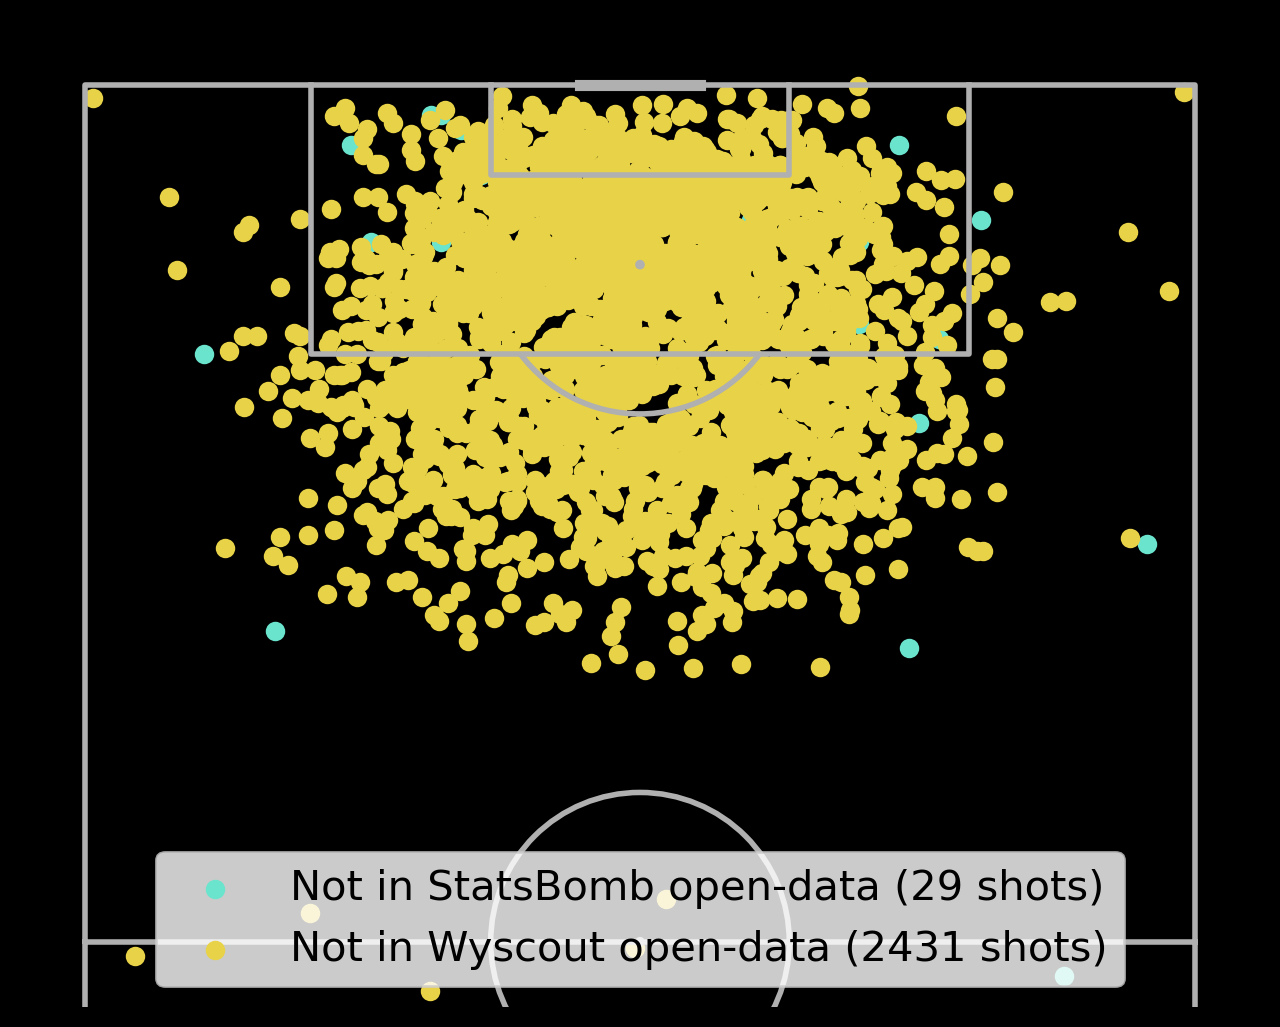

In [74]:
pitch = VerticalPitch(pitch_type='uefa', half=True, pitch_color='black', line_zorder=3)
fig, ax = pitch.draw(figsize=(8, 9), constrained_layout=True, tight_layout=False)
pitch.scatter(df_wyscout_unmatched.x, df_wyscout_unmatched.y, ax=ax, c='#6ae4cd',
              label=f'Not in StatsBomb open-data ({len(df_wyscout_unmatched)} shots)')
pitch.scatter(df_statsbomb_unmatched.x, df_statsbomb_unmatched.y, ax=ax, c='#e8d247',
              label=f'Not in Wyscout open-data ({len(df_statsbomb_unmatched)} shots)')
ax.legend(fontsize=15, loc='lower center')
fig.set_facecolor('black')
fig.savefig(os.path.join('..', 'figures', '12_overlap_shot_differences.png'),
            bbox_inches = 'tight', pad_inches = 0.2, facecolor='black')

Plot difference

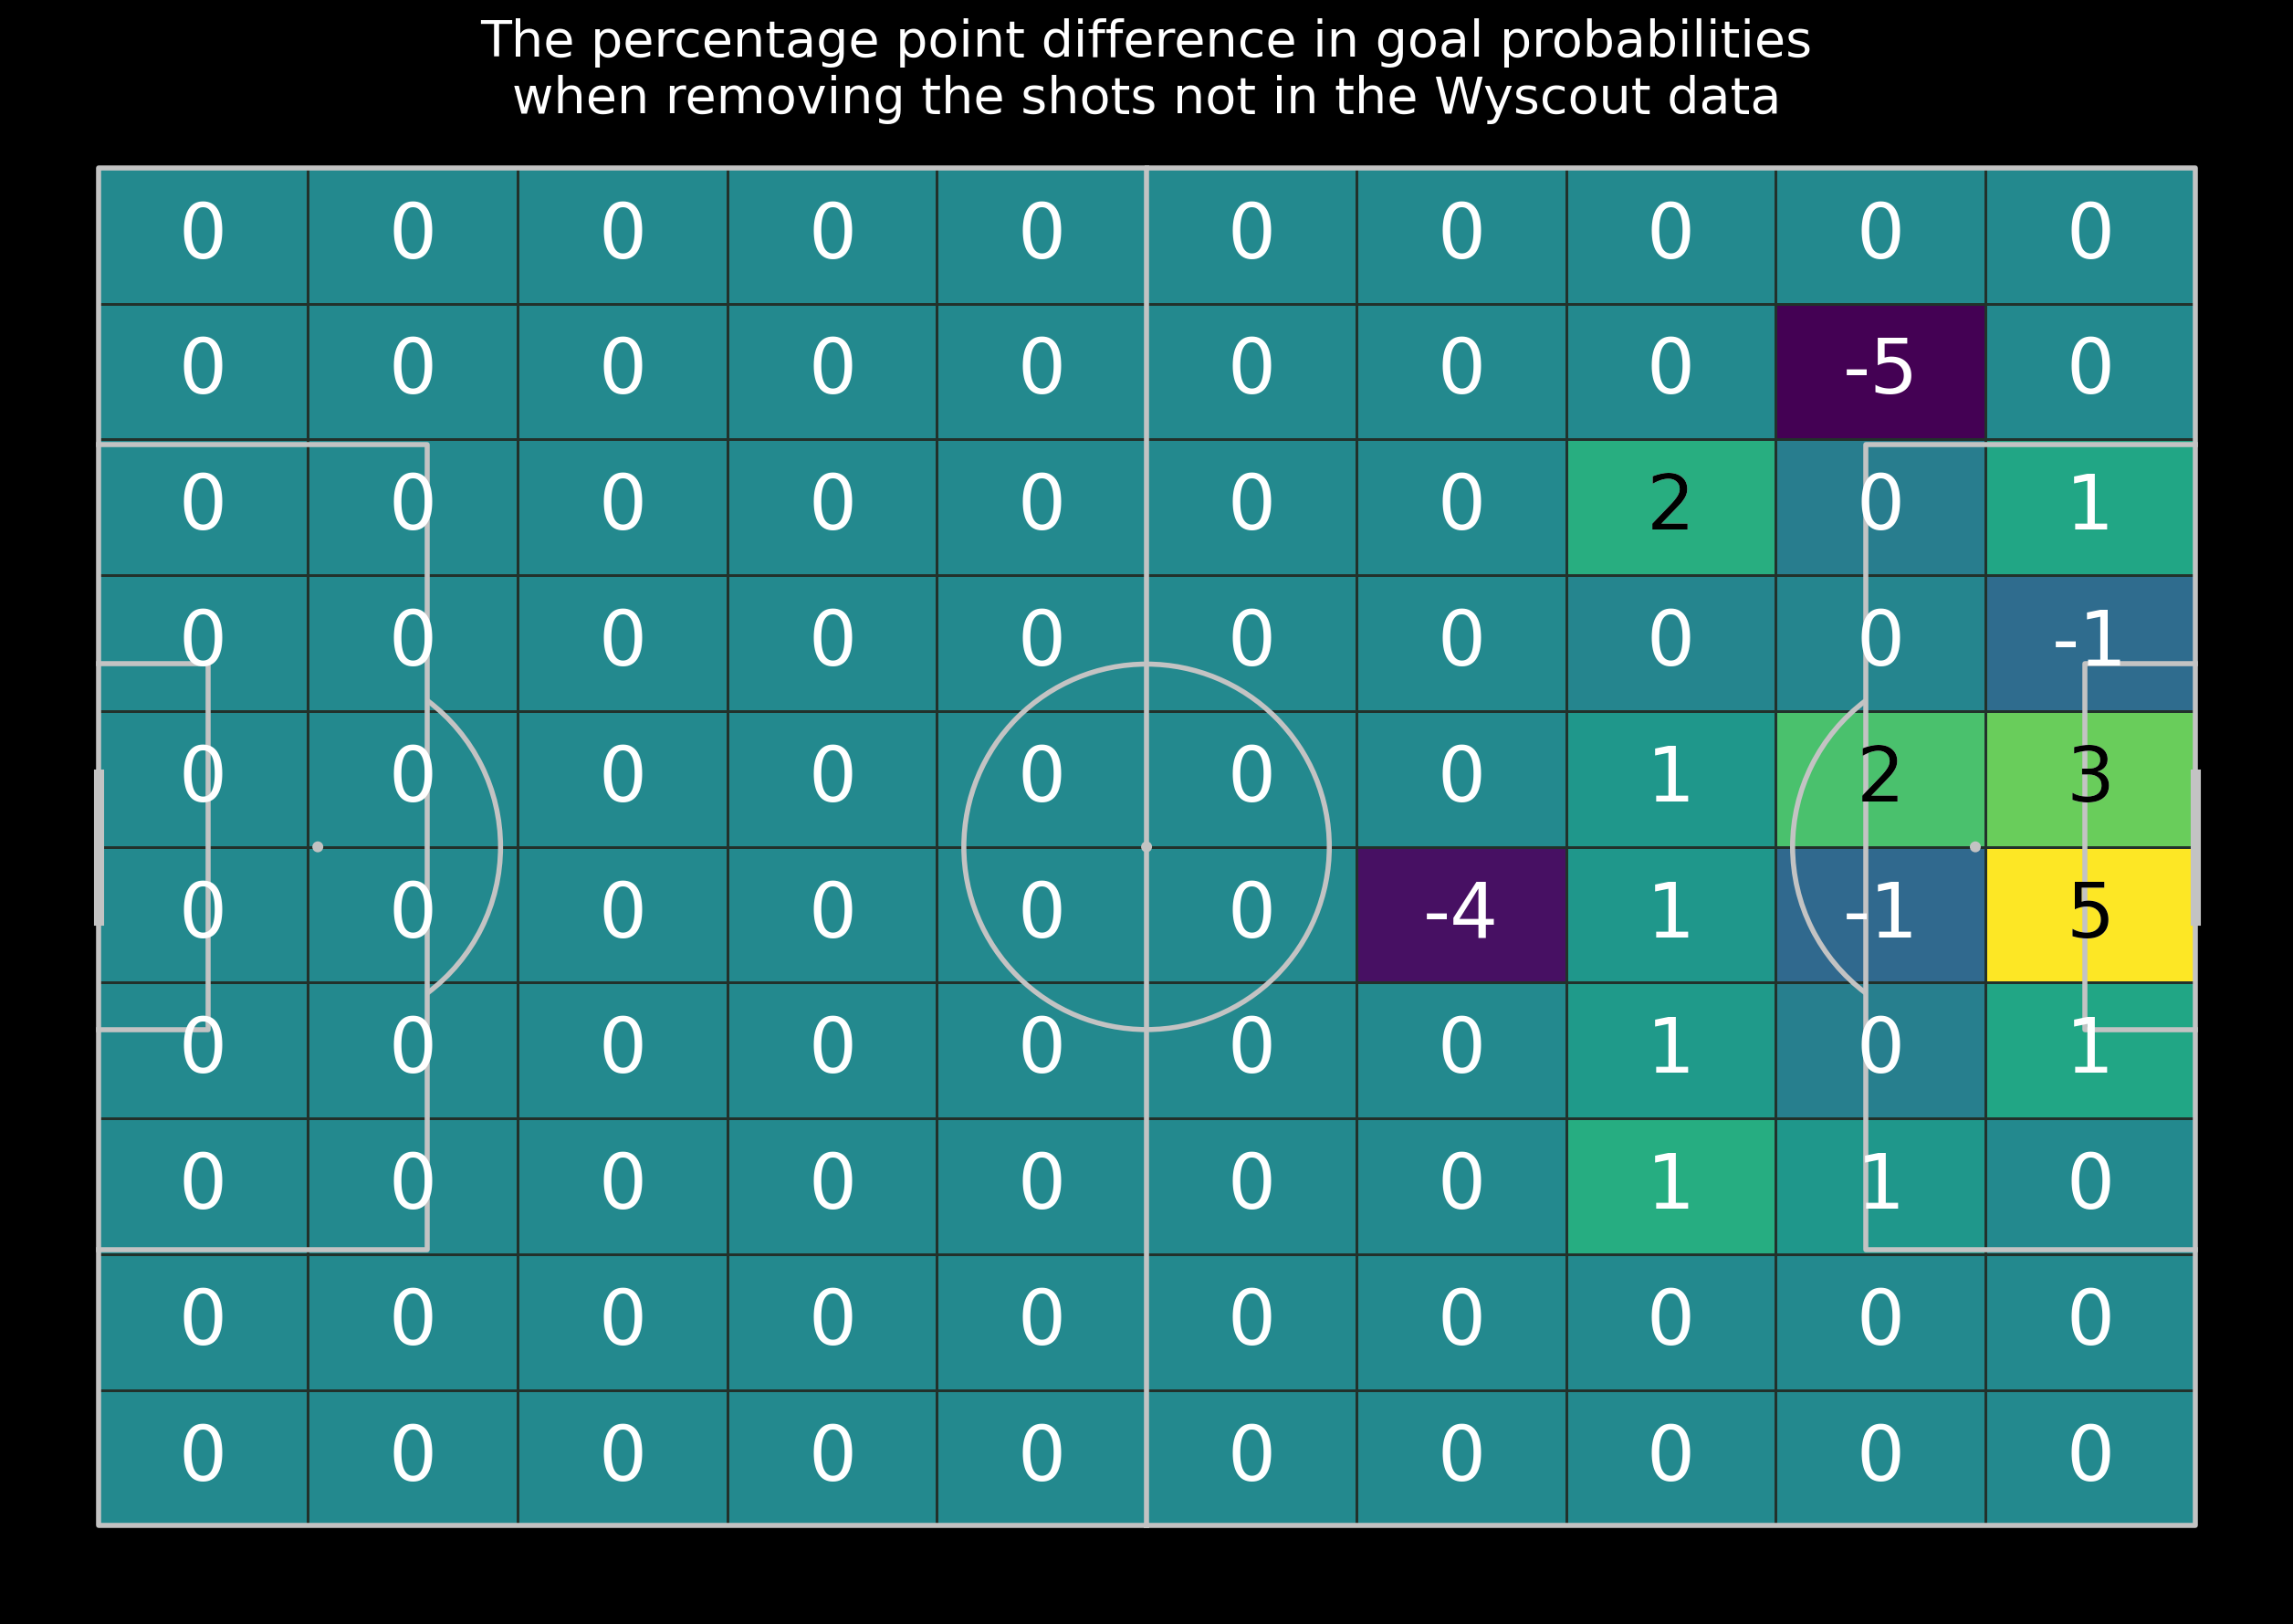

In [75]:
# goal probabilities for all shots
pitch = Pitch(pitch_type='uefa', line_zorder=3, pad_top=2,
              pitch_color='black', line_color='#C3C3C3')
mask_goal = df_statsbomb_shots.outcome_name == 'Goal'
bin_statistic_sb = pitch.bin_statistic(df_statsbomb_shots.x,
                                       df_statsbomb_shots.y,
                                       mask_goal,
                                       statistic='mean',
                                       bins=(5, 5))
# goal probabilities for matched shots
mask_goal = df_matched_shots.outcome_name == 'Goal'
bin_statistic_match = pitch.bin_statistic(df_matched_shots.x_statsbomb,
                                          df_matched_shots.y_statsbomb,
                                          mask_goal,
                                          statistic='mean',
                                          bins=(5, 5))
# goal probabilities for all shots
mask_goal = df_statsbomb_shots.outcome_name == 'Goal'
bin_statistic_sb = pitch.bin_statistic(df_statsbomb_shots.x,
                                       df_statsbomb_shots.y,
                                       mask_goal,
                                       statistic='mean',
                                       bins=(10, 10))
# goal probabilities for matched shots
mask_goal = df_matched_shots.outcome_name == 'Goal'
bin_statistic_match = pitch.bin_statistic(df_matched_shots.x_statsbomb,
                                          df_matched_shots.y_statsbomb,
                                          mask_goal,
                                          statistic='mean',
                                          bins=(10, 10))

# calculate difference, i.e. what would happen if only have wyscout shots
bin_statistic_sb['statistic'] = np.nan_to_num(bin_statistic_match['statistic']) - np.nan_to_num(bin_statistic_sb['statistic'])

fig, ax = pitch.draw(figsize=(16, 9))
pcm = pitch.heatmap(bin_statistic_sb, ax=ax, cmap='viridis', edgecolors='#22312b', zorder=1)
bin_statistic_sb['statistic'] = np.round(bin_statistic_sb['statistic'] * 100., 0).astype(np.int32)
mask = bin_statistic_sb['statistic'] > 1
bin_statistic_sb['statistic'] = bin_statistic_sb['statistic'].astype(str)
label = pitch.label_heatmap(bin_statistic_sb, color='white', fontsize=30, ax=ax, ha='center', va='center')
bin_statistic_sb['statistic'][~mask] = ''
label = pitch.label_heatmap(bin_statistic_sb, color='black', fontsize=30, ax=ax, ha='center', va='center')
ax.set_title('The percentage point difference in goal probabilities\nwhen removing the shots not in the Wyscout data',
             fontsize=20, color='white')
fig.set_facecolor('black')
fig.savefig(os.path.join('..', 'figures', '13_overlap_shot_differences_probabilities.png'),
            bbox_inches = 'tight', facecolor='black', pad_inches = 0.2)

In [76]:
df_statsbomb_unmatched.outcome_name.value_counts()

outcome_name
Off T               767
Blocked             621
Saved               532
Goal                228
Wayward             220
Post                 53
Saved Off Target      5
Saved to Post         5
Name: count, dtype: int64

In [77]:
df_statsbomb_unmatched.body_part_name.value_counts() / len(df_statsbomb_unmatched.body_part_name)

body_part_name
Right Foot    0.511724
Left Foot     0.307692
Head          0.173180
Other         0.007404
Name: count, dtype: float64

In [78]:
df_statsbomb_unmatched[df_statsbomb_unmatched.body_part_name != 'Head'].outcome_name.value_counts()

outcome_name
Off T               611
Blocked             564
Saved               461
Goal                192
Wayward             130
Post                 43
Saved to Post         5
Saved Off Target      4
Name: count, dtype: int64

In [79]:
df_statsbomb_unmatched[df_statsbomb_unmatched.body_part_name == 'Head'].outcome_name.value_counts()

outcome_name
Off T               156
Wayward              90
Saved                71
Blocked              57
Goal                 36
Post                 10
Saved Off Target      1
Name: count, dtype: int64

In [80]:
wayward = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Wayward']
blocked = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Blocked']
off_target = df_statsbomb_unmatched[df_statsbomb_unmatched.outcome_name == 'Off T']
other = df_statsbomb_unmatched[~df_statsbomb_unmatched.outcome_name.isin(['Wayward', 'Blocked', 'Off T'])]

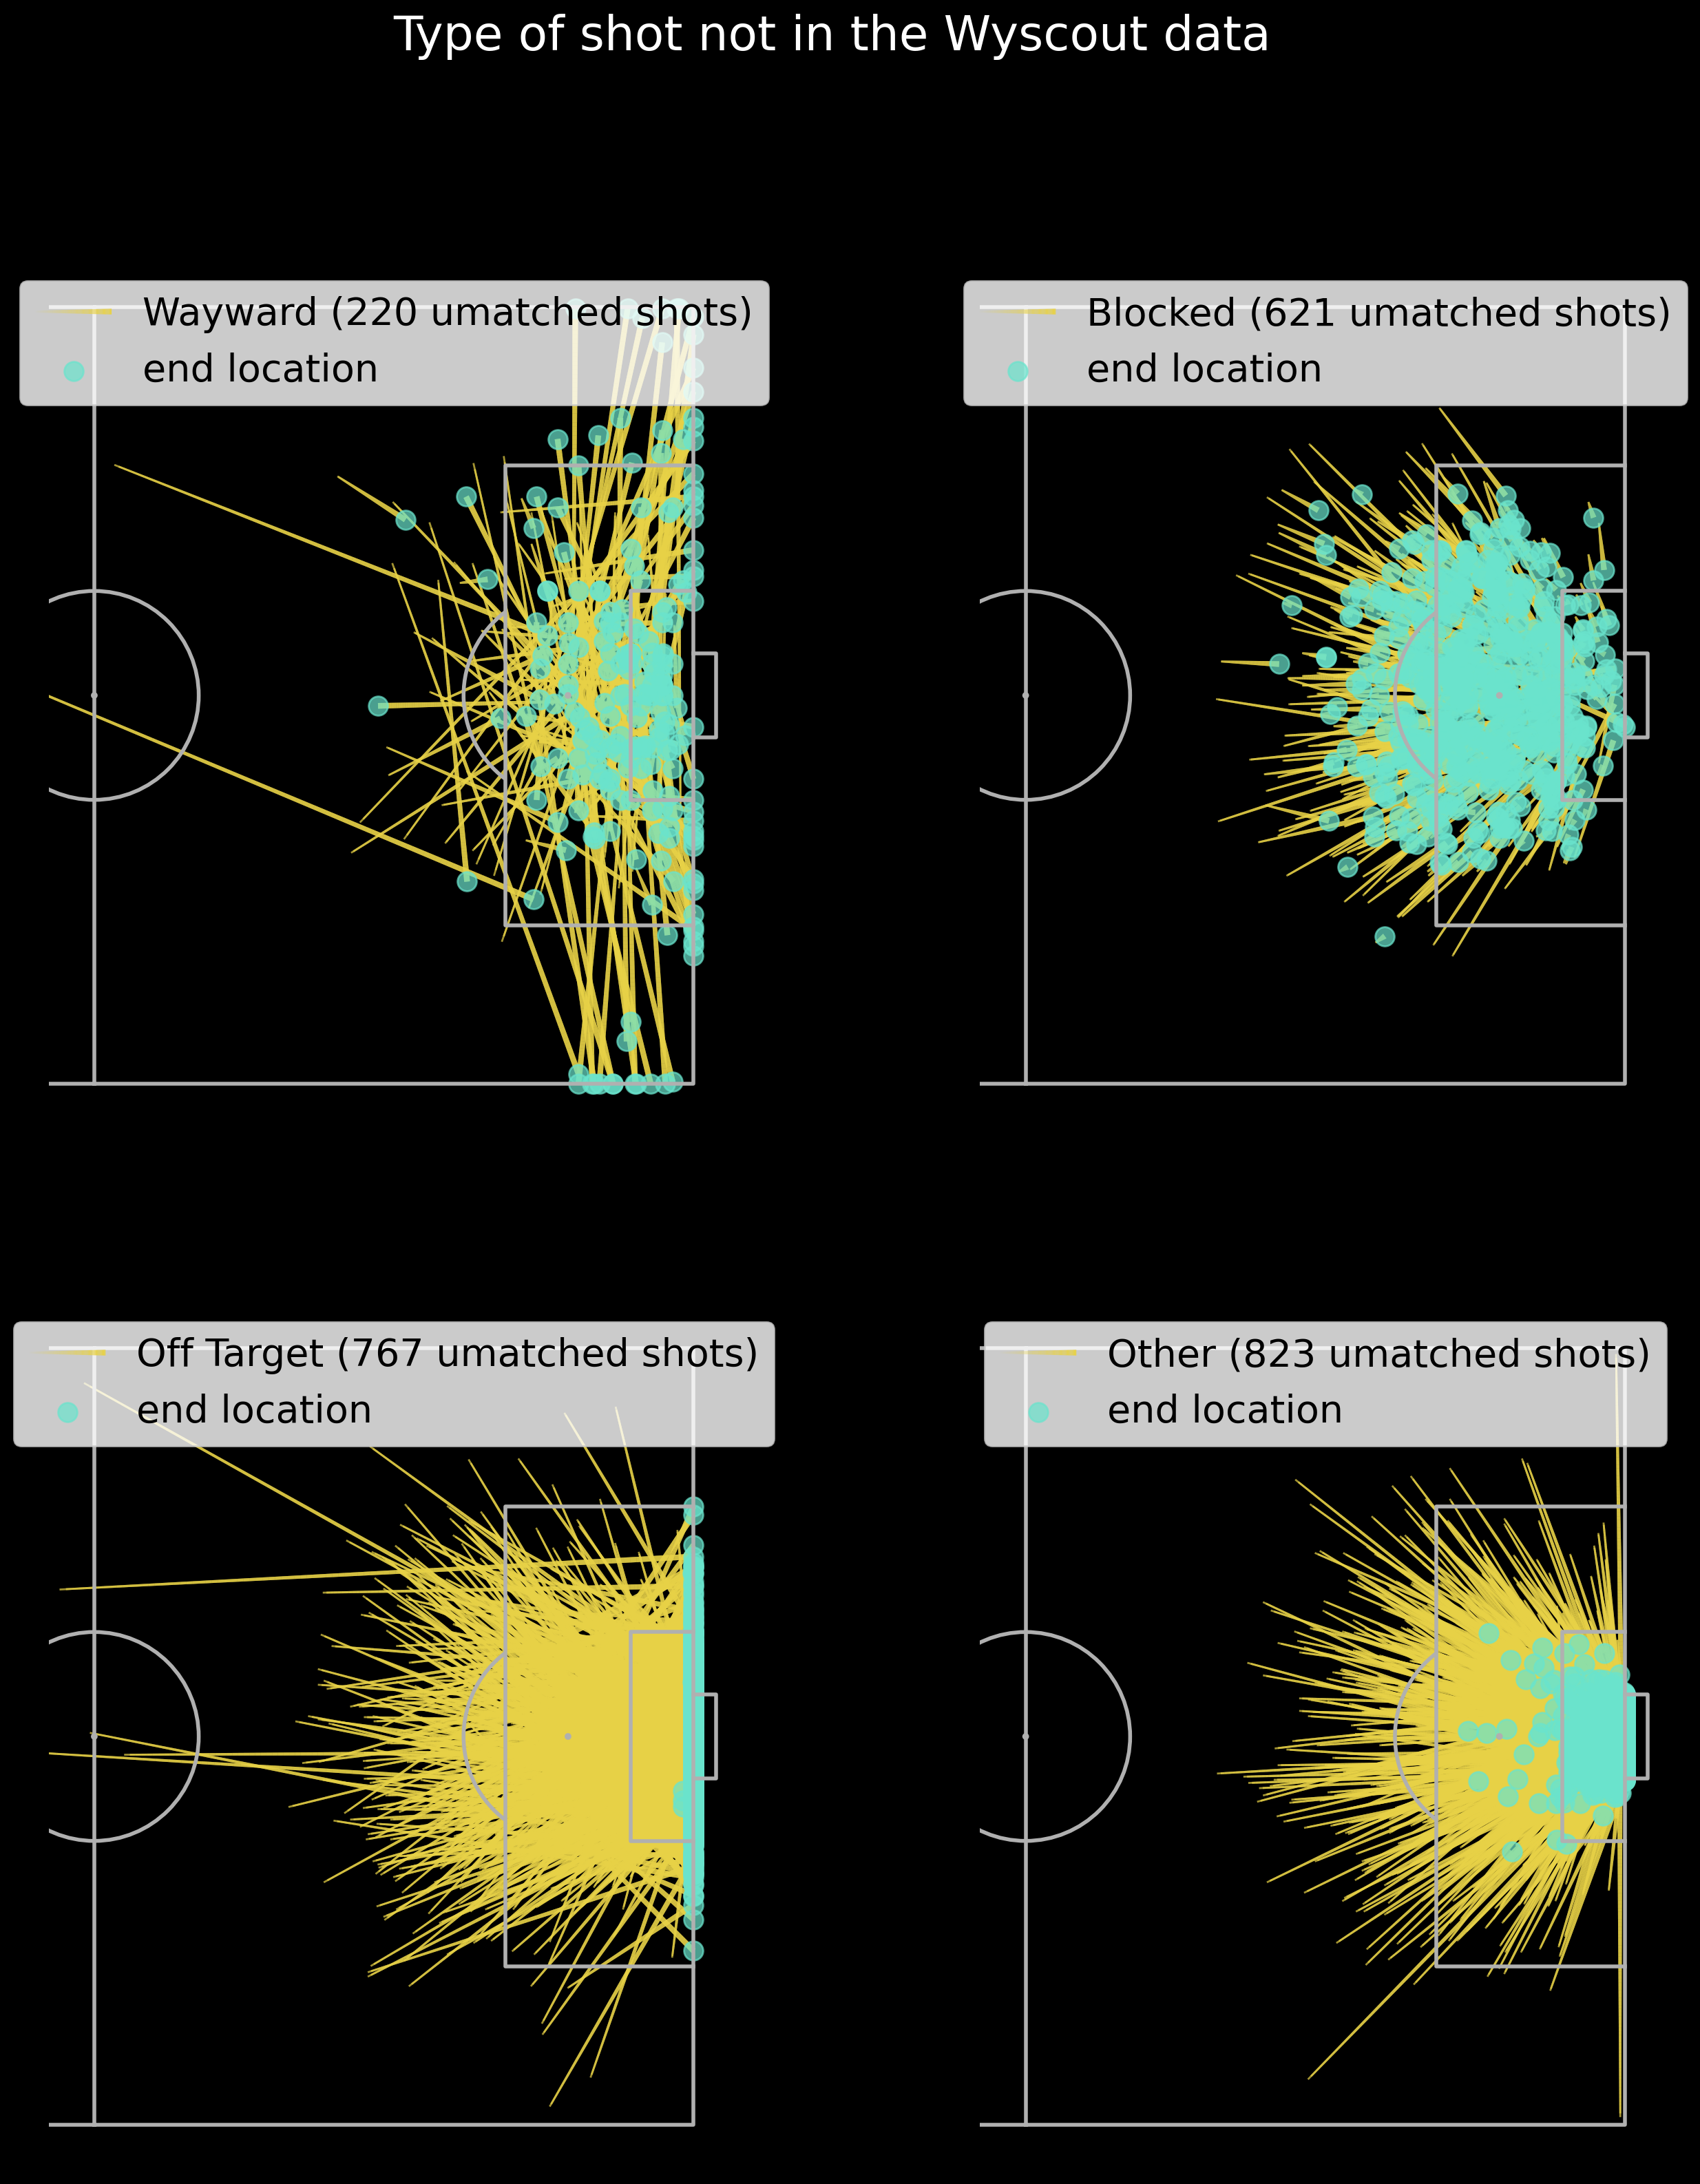

In [81]:
pitch_grid = Pitch(pitch_type='uefa', half=True, pitch_color='black',
                   line_zorder=3, goal_type='box')
fig, ax = pitch_grid.draw(figsize=(16, 18), nrows=2, ncols=2, constrained_layout=True, tight_layout=False)
ax = ax.ravel()
labels = ['Wayward', 'Blocked', 'Off Target', 'Other']
for i, df in enumerate([wayward, blocked, off_target, other]):
    pitch_grid.lines(df.x, df.y, df.end_x, df.end_y, alpha=0.7,
                     ax=ax[i], color='#e8d247', comet=True, transparent=True, lw=3,
                     label=f'{labels[i]} ({len(df)} umatched shots)')
    pitch_grid.scatter(df.end_x, df.end_y, ax=ax[i], s=100, c='#6ae4cd', alpha=0.7,
                       label='end location', zorder=2)
    ax[i].legend(loc='upper center', fontsize=20)
fig.suptitle('Type of shot not in the Wyscout data', fontsize=25, color='white')
fig.set_facecolor('black')
fig.savefig(os.path.join('..', 'figures', '14_overlap_shot_type_unmatched.png'),
            bbox_inches='tight', pad_inches=0.2, facecolor='black')

Average distance between StatsBomb and Wyscout shot locations

In [82]:
distance = ((df_matched_shots.x_statsbomb - df_matched_shots.x_wyscout)**2 +
            (df_matched_shots.y_statsbomb - df_matched_shots.y_wyscout)**2)**0.5

In [83]:
x_diff = df_matched_shots.x_statsbomb - df_matched_shots.x_wyscout
y_diff = df_matched_shots.y_statsbomb - df_matched_shots.y_wyscout

In [84]:
pd.DataFrame({'x_diff': x_diff, 'y_diff': y_diff, 'distance': distance}).describe()

,x_diff,y_diff,distance
count,2304.000000,2304.000000,2304.000000
mean,1.006245,-0.177063,3.669820
std,3.991660,3.584249,4.043648
min,-16.750000,-20.000556,0.040774
25%,-0.518067,-2.029762,1.741935
50%,0.583613,-0.152778,2.890434
75%,2.291667,1.520139,4.429877
max,84.375000,31.917222,86.000068


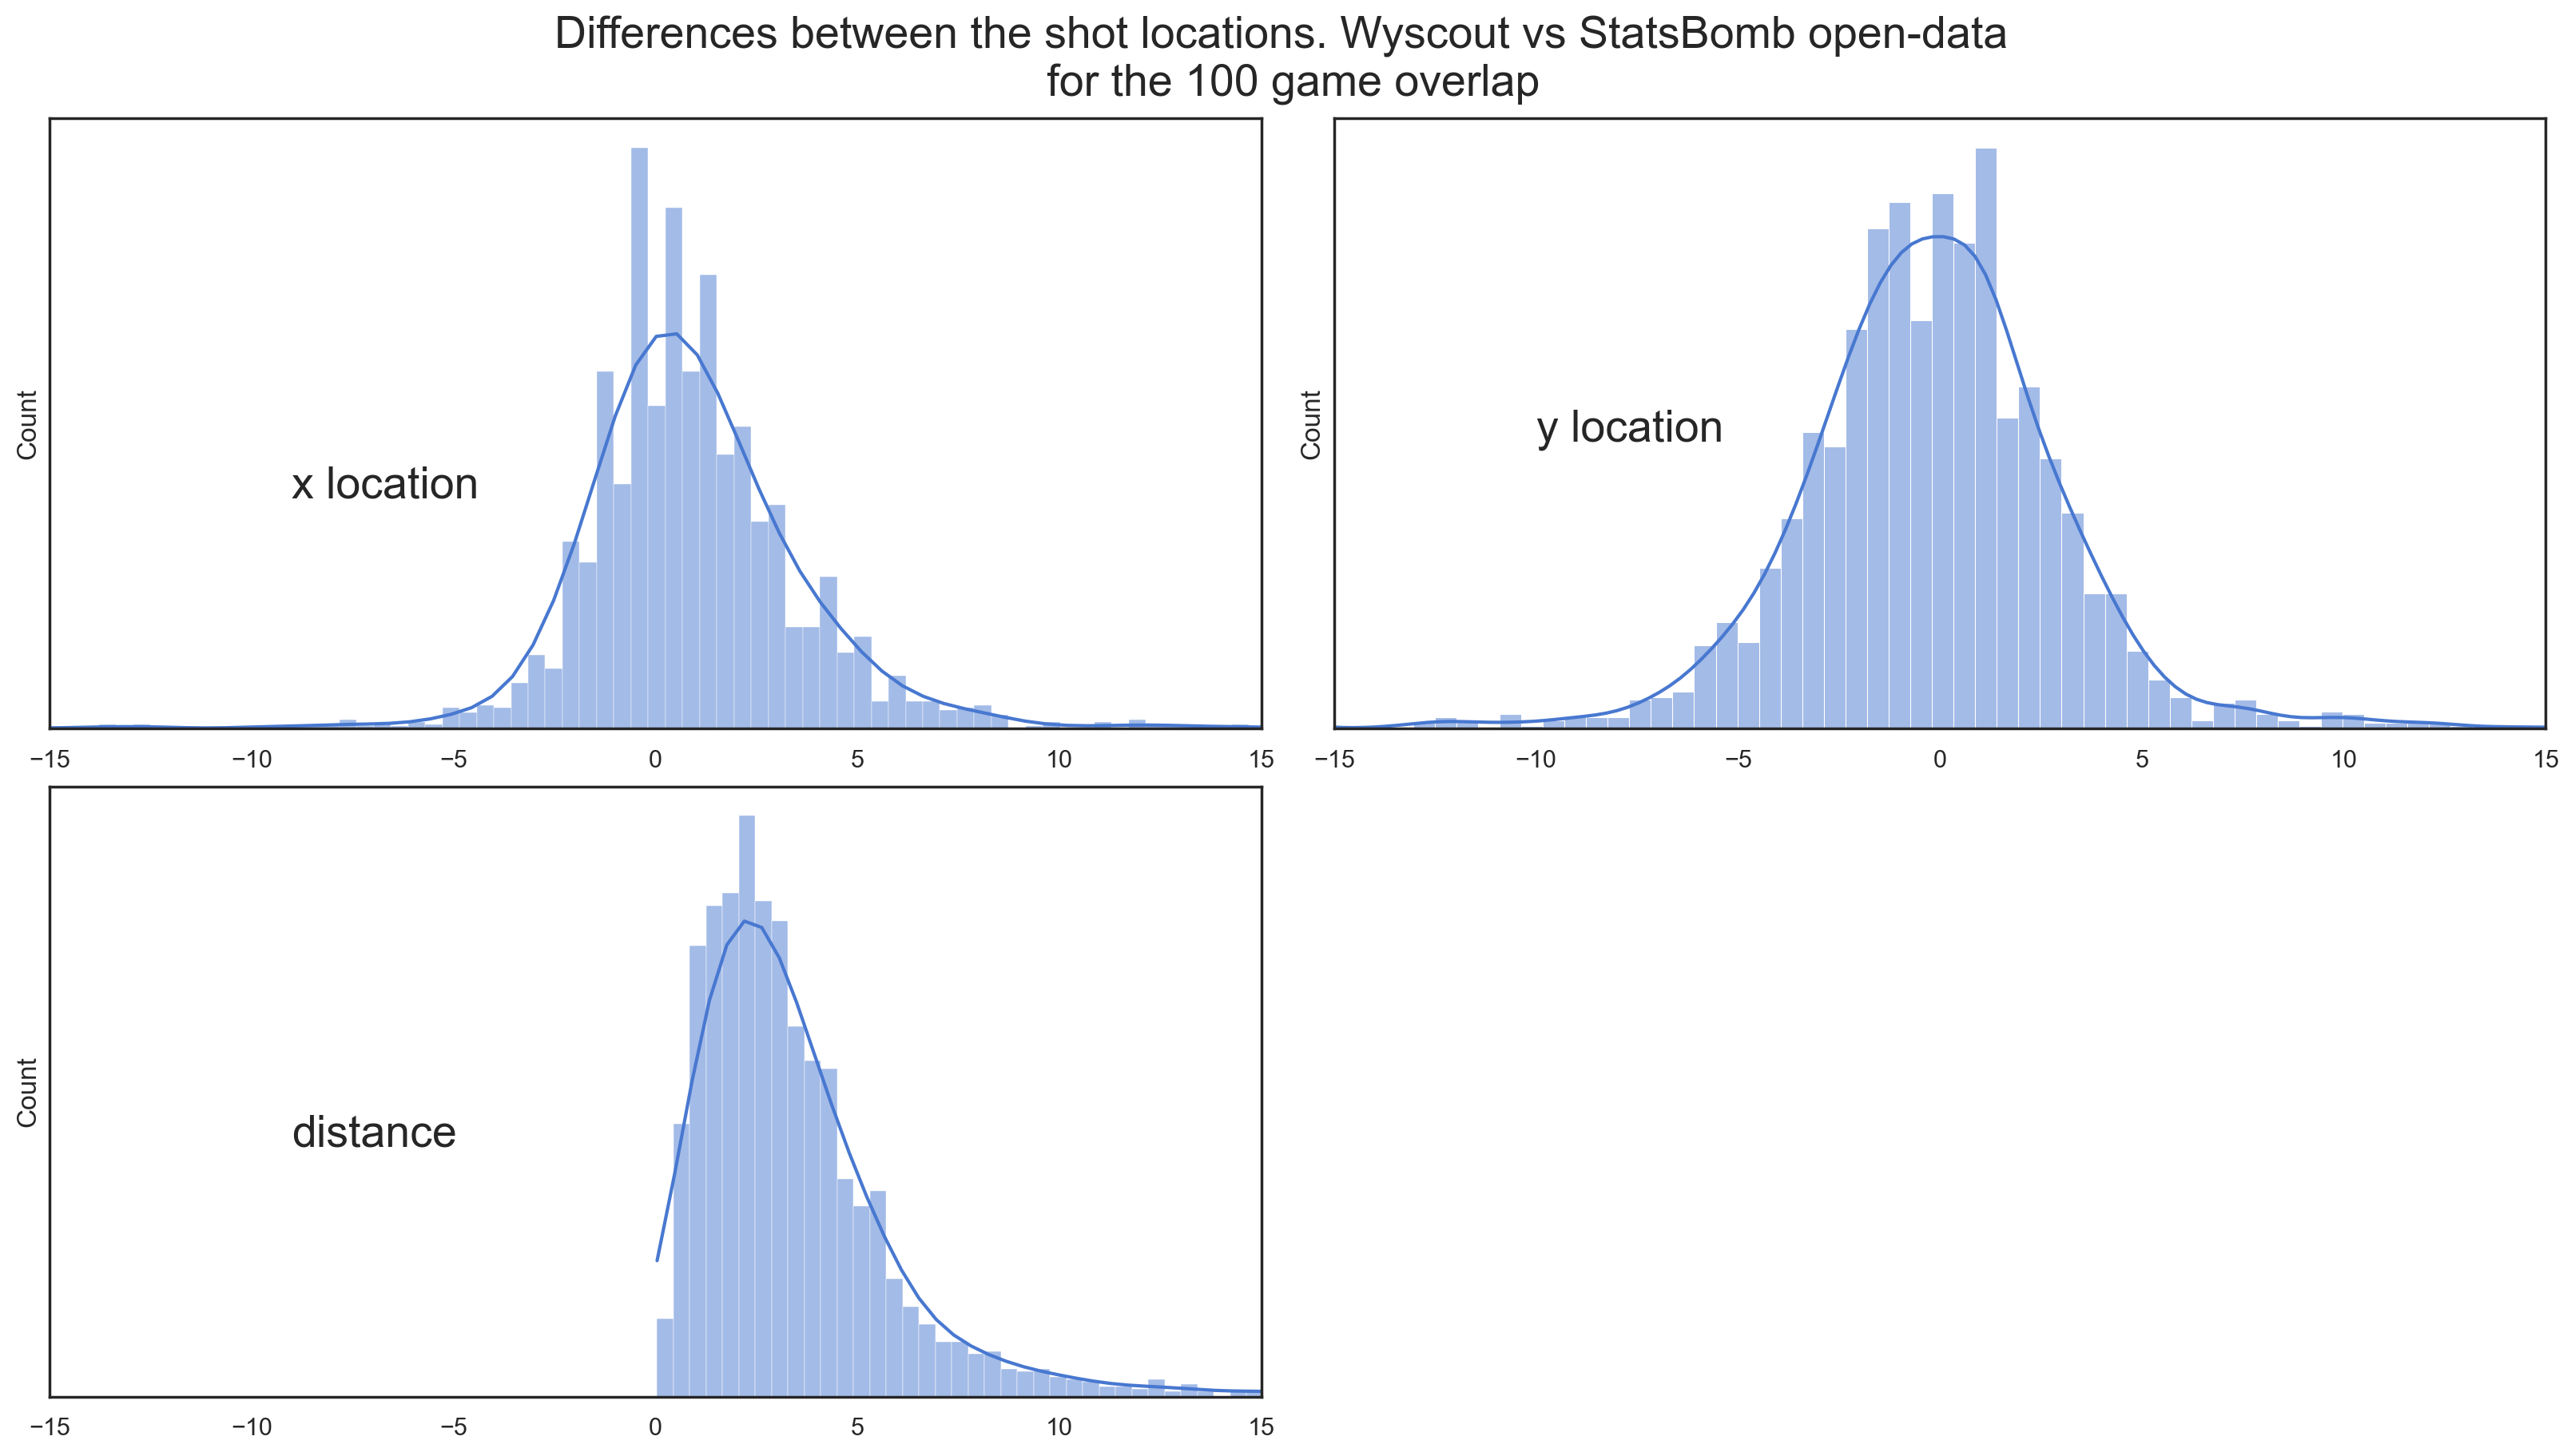

In [85]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(style="white", palette="muted", color_codes=True)
fig, ax  = plt.subplots(2, 2, figsize=(16, 9), constrained_layout=True)
sns.histplot(x_diff, kde=True, ax=ax[0, 0])
sns.histplot(y_diff, kde=True, ax=ax[0, 1])
sns.histplot(distance, kde=True, ax=ax[1, 0])
plt.setp(ax, yticks=[])
ax[0, 0].set_xlim(-15, 15)
ax[0, 0].annotate('x location', (-9, 100), fontsize=20)
ax[0, 1].set_xlim(-15, 15)
ax[0, 1].annotate('y location', (-10, 100), fontsize=20)
ax[1, 0].set_xlim(-15, 15)
ax[1, 0].annotate('distance', (-9, 100), fontsize=20)
ax[1, 1].remove()
fig.suptitle('Differences between the shot locations. Wyscout vs StatsBomb open-data \n for the 100 game overlap', fontsize=20)
plt.show()
fig.savefig(os.path.join('..', 'figures', '15_overlap_difference_distribution.png'), bbox_inches = 'tight', pad_inches = 0.2)

Plots example match

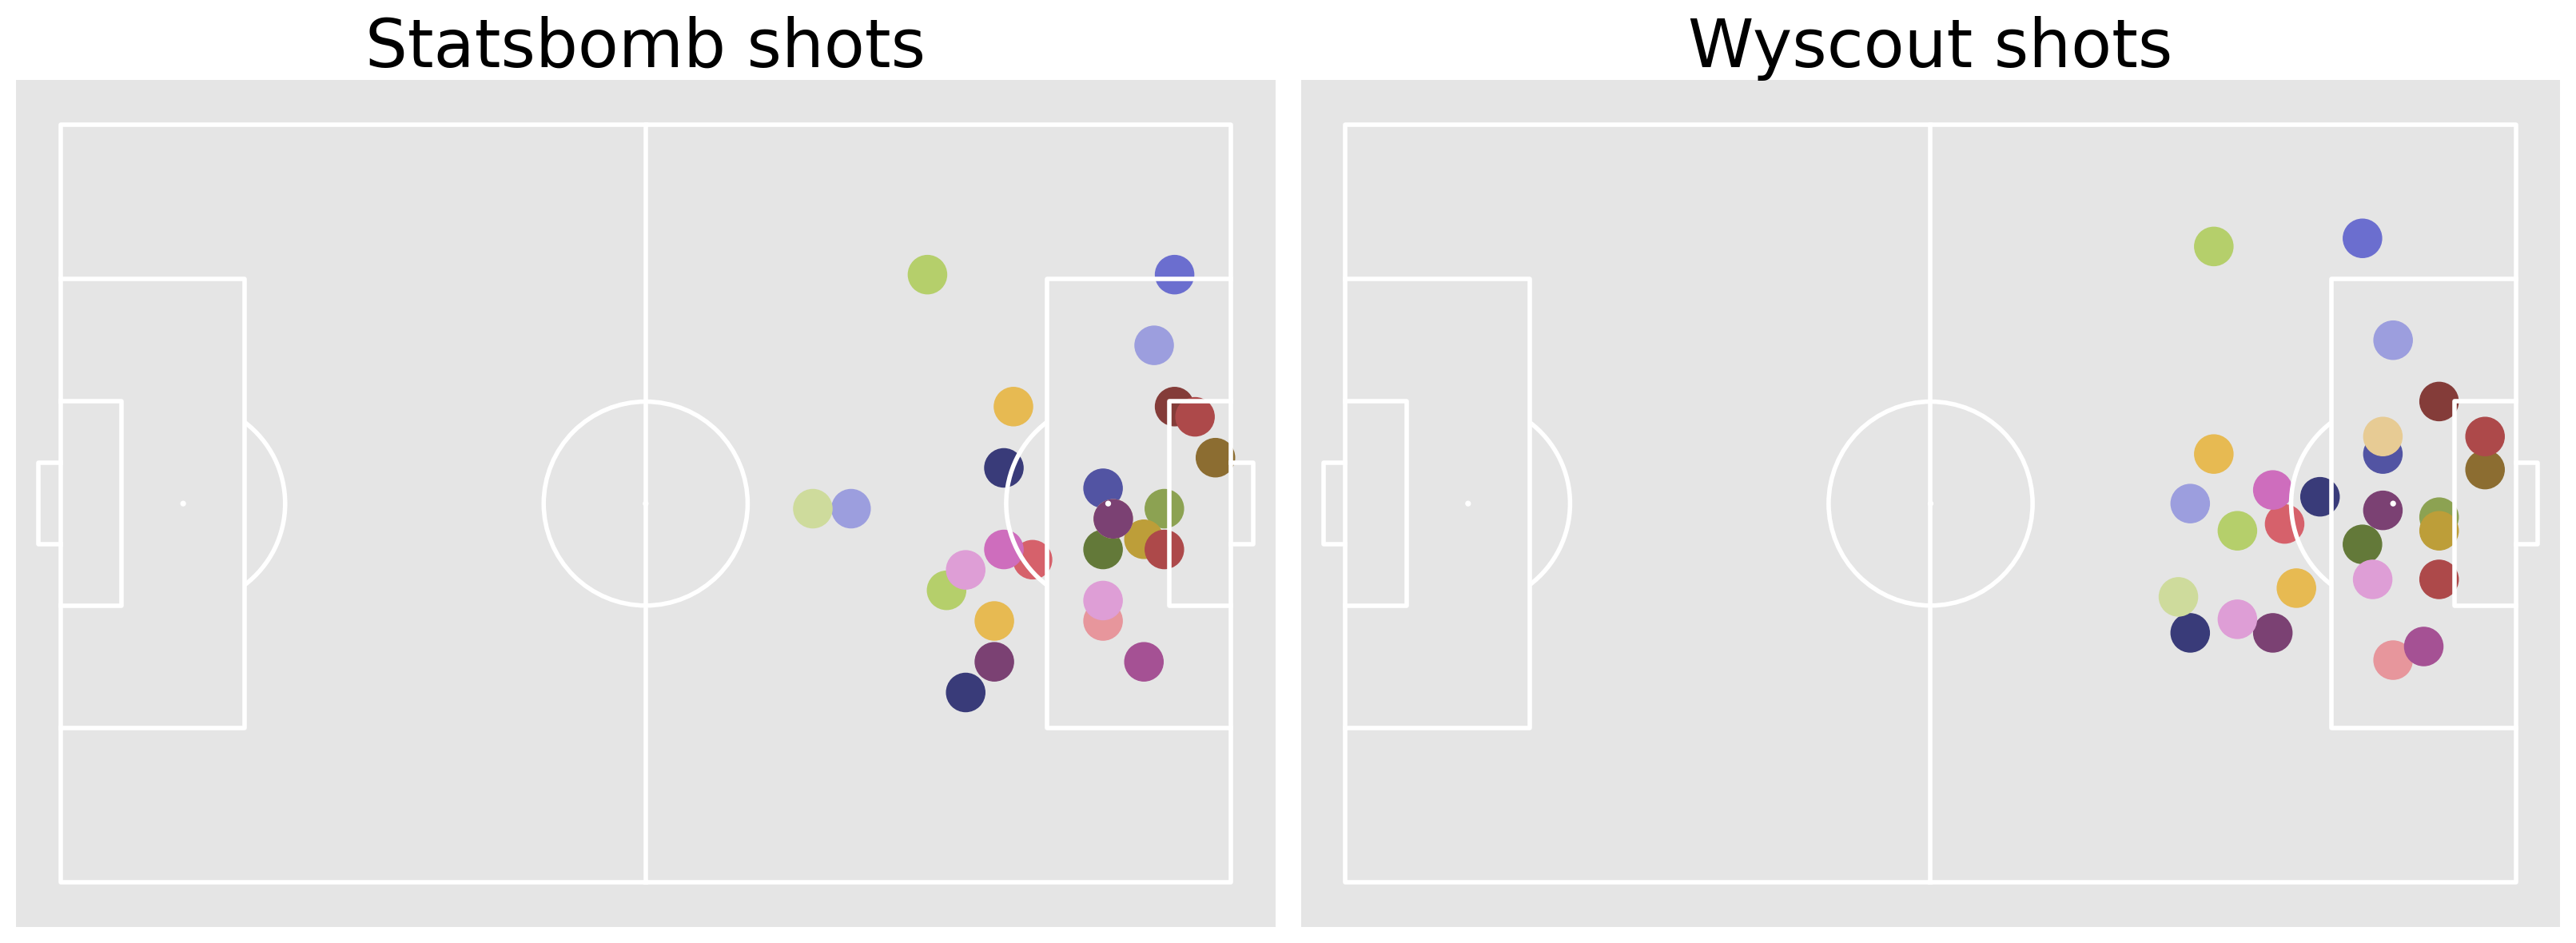

In [86]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('ggplot')
pitch = Pitch(pitch_type='uefa', line_zorder=3, goal_type='box')
all_ids = df_statsbomb_shots.match_id_wyscout.unique()
idx = 1
subset = df_matched_shots[df_matched_shots.match_id_wyscout == all_ids[idx]].copy()
subset_match = df_wyscout_match[df_wyscout_match.match_id == all_ids[idx]]
team1 = subset_match.home_team_name.values[0]
team2 = subset_match.away_team_name.values[0]
fig, ax  = plt.subplots(1, 2, figsize=(16, 9), constrained_layout=True)
pitch.draw(ax=ax[0])
pitch.scatter(subset.x_statsbomb, subset.y_statsbomb, c=np.arange(subset.y_statsbomb.size),
              cmap='tab20b', ax=ax[0], s=300)
ax[0].set_title('Statsbomb shots', fontsize=30, color='black')
pitch.draw(ax=ax[1])
pitch.scatter(subset.x_wyscout, subset.y_wyscout, c=np.arange(subset.y_statsbomb.size),
                           cmap='tab20b', ax=ax[1], s=300)
ax[1].set_title('Wyscout shots', fontsize=30, color='black')
plt.show()
fig.savefig(os.path.join('..', 'figures', '16_overlap_difference_example.png'), bbox_inches = 'tight', pad_inches = 0.2)